In [73]:
import numpy as np

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / np.sum(e_x, axis=1, keepdims=True)

def cross_entropy_loss(predictions, labels,reg_lambda):
    predictions = np.clip(predictions, 1e-9, 1 - 1e-9)
    m = labels.shape[0]
    log_probs = -np.log(predictions[np.arange(m), labels])
    loss = np.sum(log_probs) / m
    return loss

def to_categorical(y, num_classes):
    """ Convert vector of labels to one-hot encoding """
    return np.eye(num_classes)[y]

class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, activate_model=relu, activation_derivative=relu_derivative):
        self.params = {
            'W1': np.random.randn(input_size, hidden_size) * np.sqrt(2. / input_size),
            'b1': np.zeros(hidden_size),
            'W2': np.random.randn(hidden_size, hidden_size) * np.sqrt(2. / hidden_size),
            'b2': np.zeros(hidden_size),
            'W3': np.random.randn(hidden_size, output_size) * np.sqrt(2. / hidden_size),
            'b3': np.zeros(output_size)
        }
        self.activate_model = activate_model
        self.activation_derivative = activation_derivative
    
    def forward(self, X):
        self.cache = {}
        # Layer 1
        self.cache['Z1'] = np.dot(X, self.params['W1']) + self.params['b1']
        self.cache['A1'] = self.activate_model(self.cache['Z1'])
        # Layer 2
        self.cache['Z2'] = np.dot(self.cache['A1'], self.params['W2']) + self.params['b2']
        self.cache['A2'] = self.activate_model(self.cache['Z2'])
        # Layer 3
        self.cache['Z3'] = np.dot(self.cache['A2'], self.params['W3']) + self.params['b3']
        self.cache['A3'] = softmax(self.cache['Z3'])
        return self.cache['A3']
    
    def backward(self, X, y):
        m = X.shape[0]
        y_true = to_categorical(y, self.params['W3'].shape[1])

        # Gradient for Layer 3
        dZ3 = self.cache['A3'] - y_true
        dW3 = np.dot(self.cache['A2'].T, dZ3) / m
        db3 = np.sum(dZ3, axis=0) / m

        # Gradient for Layer 2
        dA2 = np.dot(dZ3, self.params['W3'].T)
        dZ2 = dA2 * self.activation_derivative(self.cache['Z2'])
        dW2 = np.dot(self.cache['A1'].T, dZ2) / m
        db2 = np.sum(dZ2, axis=0) / m

        # Gradient for Layer 1
        dA1 = np.dot(dZ2, self.params['W2'].T)
        dZ1 = dA1 * self.activation_derivative(self.cache['Z1'])
        dW1 = np.dot(X.T, dZ1) / m
        db1 = np.sum(dZ1, axis=0) / m

        gradients = {'W1': dW1, 'b1': db1, 'W2': dW2, 'b2': db2, 'W3': dW3, 'b3': db3}
        return gradients

    def update_params(self, gradients, lr, reg_lambda):
        for key in self.params:
            self.params[key] -= lr * (gradients[key] + reg_lambda * self.params[key])



In [74]:
def evaluate_model(model, X, y):

    predictions = model.forward(X)
    predicted_labels = np.argmax(predictions, axis=1)
    accuracy = np.mean(predicted_labels == y)
    m = y.shape[0]
    y_one_hot = np.eye(model.params['W2'].shape[1])[y]  
    log_probs = -np.log(predictions[np.arange(m), y] + 1e-9)  
    loss = np.sum(log_probs) / m

    return accuracy, loss

In [75]:
import matplotlib.pyplot as plt
def train(X_train, y_train, X_val, y_val, model, epochs, batch_size, lr, reg_lambda):
    n_batches = int(np.ceil(X_train.shape[0] / batch_size))
    best_val_acc = 0
    best_params = {}
    train_losses = []
    val_accuracys=[]
    val_losses=[]
    for epoch in range(epochs):
        # Shuffle dataset
        indices = np.arange(X_train.shape[0])
        np.random.shuffle(indices)
        X_train = X_train[indices]
        y_train = y_train[indices]
        epoch_losses = []
        for i in range(n_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, X_train.shape[0])
            
            X_batch = X_train[start_idx:end_idx]
            y_batch = y_train[start_idx:end_idx]
            # Forward and backward propagation
            output = model.forward(X_batch)
            loss=cross_entropy_loss(output,y_batch,reg_lambda)
            epoch_losses.append(loss)
            gradients = model.backward(X_batch, y_batch)
            
            # Update weights
            model.update_params(gradients, lr,reg_lambda)
        average_loss = np.mean(epoch_losses)
        train_losses.append(average_loss)
        # Validation accuracy
        val_acc,val_loss=evaluate_model(model,X_val,y_val)
        print(f'Epoch {epoch + 1}, Train Loss: {average_loss:.4f}')
        print(f'Epoch {epoch + 1}, Validation Accuracy: {val_acc:.4f}')
        val_accuracys.append(val_acc)
        val_losses.append(val_loss)
        # Check if we need to update the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_params = model.params.copy()
    print(f'Epoch {epoch + 1}, Best Validation Accuracy: {best_val_acc:.4f}')
    
    model.params = best_params
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracys)
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.show()

    return model


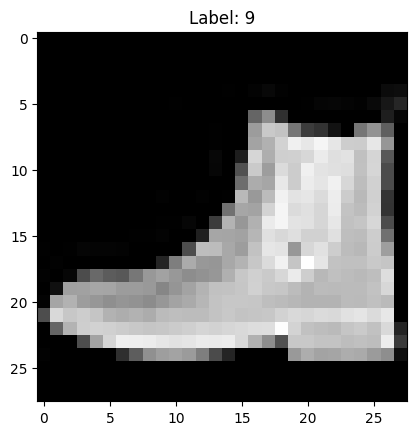

((48000, 784), (12000, 784), (10000, 784))

In [80]:
import numpy as np
import os
import struct
def load_mnist(path, kind='train'):
    """加载MNIST数据从`path`"""
    labels_path = os.path.join(path, f'{kind}-labels-idx1-ubyte')
    images_path = os.path.join(path, f'{kind}-images-idx3-ubyte')

    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)

    return images, labels
train_images, train_labels = load_mnist('data', kind='train')
test_images, test_labels = load_mnist('data', kind='t10k')
train_images, train_labels = load_mnist('data', kind='train')

num_validation_samples = int(0.2 * train_images.shape[0])

# 通常混洗数据可以提高模型的泛化能力
indices = np.arange(train_images.shape[0])
np.random.shuffle(indices)

train_images = train_images[indices]
train_labels = train_labels[indices]

val_images = train_images[:num_validation_samples]
val_labels = train_labels[:num_validation_samples]

train_images = train_images[num_validation_samples:]
train_labels = train_labels[num_validation_samples:]
import matplotlib.pyplot as plt

plt.imshow(train_images[0].reshape(28, 28), cmap='gray')
plt.title(f'Label: {train_labels[0]}')
plt.show()
train_images.shape,val_images.shape,test_images.shape

In [78]:
def grid_search(X_train, y_train, X_val, y_val, input_size, output_size):
    learning_rates = [0.0001,0.00005]
    hidden_sizes = [100, 150,200]
    reg_lambdas = [0.1,0.2]
    batch_sizes=[32,64]
    best_val_acc = 0
    best_params = {}
    results = []

# 参数搜索
    for lr in learning_rates:
        for hidden_size in hidden_sizes:
            for reg_lambda in reg_lambdas:
                for batch_size in batch_sizes:
                    model = NeuralNetwork(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
                    print(f"Training with lr={lr}, hidden_size={hidden_size}, reg_lambda={reg_lambda}, batch_size={batch_size}")
                    train(X_train, y_train, X_val, y_val, model, epochs=50, batch_size=batch_size, lr=lr, reg_lambda=reg_lambda)
                    val_acc, _ = evaluate_model(model, X_val, y_val)
                    results.append((lr, hidden_size, reg_lambda, batch_size, val_acc))
                    print(f"Validation accuracy: {val_acc:.4f}")
                    if val_acc > best_val_acc:
                        best_val_acc = val_acc
                        best_params = {'lr': lr, 'hidden_size': hidden_size, 'reg_lambda': reg_lambda, 'batch_size': batch_size}
                        print(f"New best params found: {best_params}, val_acc: {val_acc:.4f}")

    # 保存或返回结果
    return best_params, best_val_acc, results


Training with lr=0.0001, hidden_size=100, reg_lambda=0.1, batch_size=32
Epoch 1, Train Loss: 3.4506
Epoch 1, Validation Accuracy: 0.7236
Epoch 2, Train Loss: 1.5453
Epoch 2, Validation Accuracy: 0.7316
Epoch 3, Train Loss: 1.1144
Epoch 3, Validation Accuracy: 0.7478
Epoch 4, Train Loss: 0.9037
Epoch 4, Validation Accuracy: 0.7665
Epoch 5, Train Loss: 0.7757
Epoch 5, Validation Accuracy: 0.7790
Epoch 6, Train Loss: 0.6921
Epoch 6, Validation Accuracy: 0.7836
Epoch 7, Train Loss: 0.6378
Epoch 7, Validation Accuracy: 0.7912
Epoch 8, Train Loss: 0.5943
Epoch 8, Validation Accuracy: 0.7933
Epoch 9, Train Loss: 0.5627
Epoch 9, Validation Accuracy: 0.7913
Epoch 10, Train Loss: 0.5396
Epoch 10, Validation Accuracy: 0.8049
Epoch 11, Train Loss: 0.5153
Epoch 11, Validation Accuracy: 0.8019
Epoch 12, Train Loss: 0.4999
Epoch 12, Validation Accuracy: 0.7956
Epoch 13, Train Loss: 0.4852
Epoch 13, Validation Accuracy: 0.7994
Epoch 14, Train Loss: 0.4728
Epoch 14, Validation Accuracy: 0.8049
Epoch 15

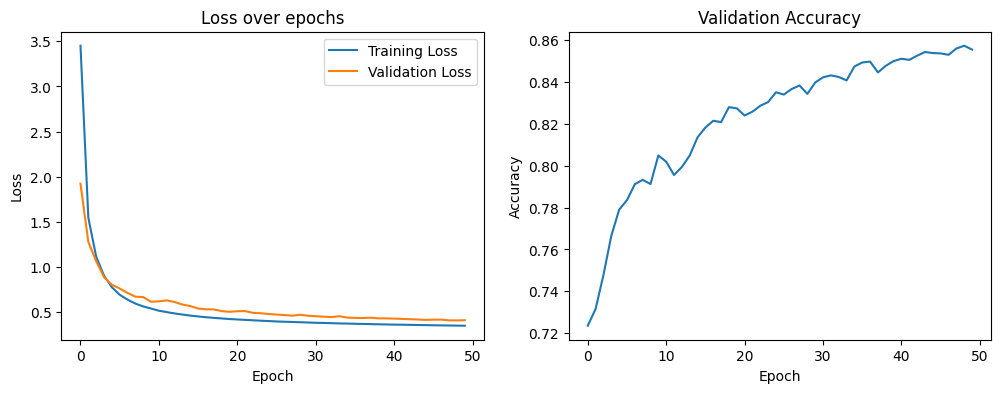

Validation accuracy: 0.8555
New best params found: {'lr': 0.0001, 'hidden_size': 100, 'reg_lambda': 0.1, 'batch_size': 32}, val_acc: 0.8555
Training with lr=0.0001, hidden_size=100, reg_lambda=0.1, batch_size=64
Epoch 1, Train Loss: 4.2703
Epoch 1, Validation Accuracy: 0.7243
Epoch 2, Train Loss: 2.1617
Epoch 2, Validation Accuracy: 0.7346
Epoch 3, Train Loss: 1.6155
Epoch 3, Validation Accuracy: 0.7401
Epoch 4, Train Loss: 1.3298
Epoch 4, Validation Accuracy: 0.7570
Epoch 5, Train Loss: 1.1469
Epoch 5, Validation Accuracy: 0.7632
Epoch 6, Train Loss: 1.0180
Epoch 6, Validation Accuracy: 0.7689
Epoch 7, Train Loss: 0.9251
Epoch 7, Validation Accuracy: 0.7657
Epoch 8, Train Loss: 0.8488
Epoch 8, Validation Accuracy: 0.7716
Epoch 9, Train Loss: 0.7992
Epoch 9, Validation Accuracy: 0.7736
Epoch 10, Train Loss: 0.7511
Epoch 10, Validation Accuracy: 0.7751
Epoch 11, Train Loss: 0.7159
Epoch 11, Validation Accuracy: 0.7566
Epoch 12, Train Loss: 0.6790
Epoch 12, Validation Accuracy: 0.7847
Ep

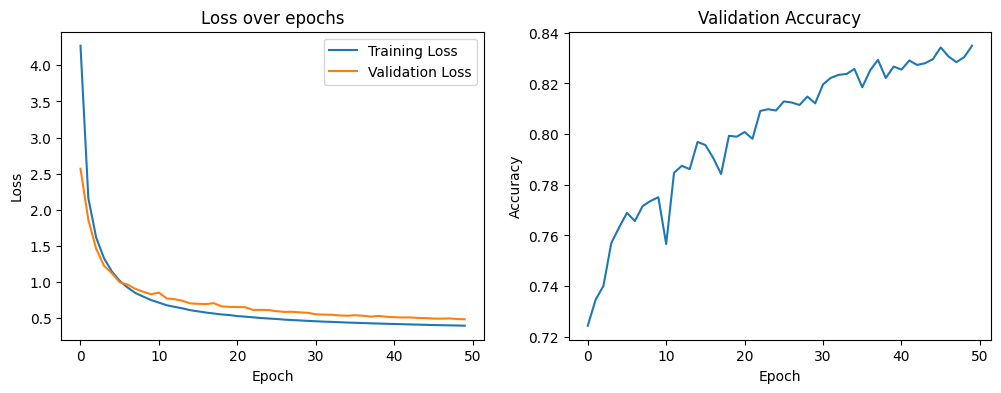

Validation accuracy: 0.8349
Training with lr=0.0001, hidden_size=100, reg_lambda=0.2, batch_size=32
Epoch 1, Train Loss: 3.4678
Epoch 1, Validation Accuracy: 0.6970
Epoch 2, Train Loss: 1.5072
Epoch 2, Validation Accuracy: 0.7306
Epoch 3, Train Loss: 1.0921
Epoch 3, Validation Accuracy: 0.7107
Epoch 4, Train Loss: 0.8896
Epoch 4, Validation Accuracy: 0.7537
Epoch 5, Train Loss: 0.7715
Epoch 5, Validation Accuracy: 0.7657
Epoch 6, Train Loss: 0.6869
Epoch 6, Validation Accuracy: 0.7786
Epoch 7, Train Loss: 0.6277
Epoch 7, Validation Accuracy: 0.7828
Epoch 8, Train Loss: 0.5823
Epoch 8, Validation Accuracy: 0.7878
Epoch 9, Train Loss: 0.5464
Epoch 9, Validation Accuracy: 0.7995
Epoch 10, Train Loss: 0.5191
Epoch 10, Validation Accuracy: 0.8080
Epoch 11, Train Loss: 0.4980
Epoch 11, Validation Accuracy: 0.8125
Epoch 12, Train Loss: 0.4791
Epoch 12, Validation Accuracy: 0.8148
Epoch 13, Train Loss: 0.4618
Epoch 13, Validation Accuracy: 0.8198
Epoch 14, Train Loss: 0.4493
Epoch 14, Validati

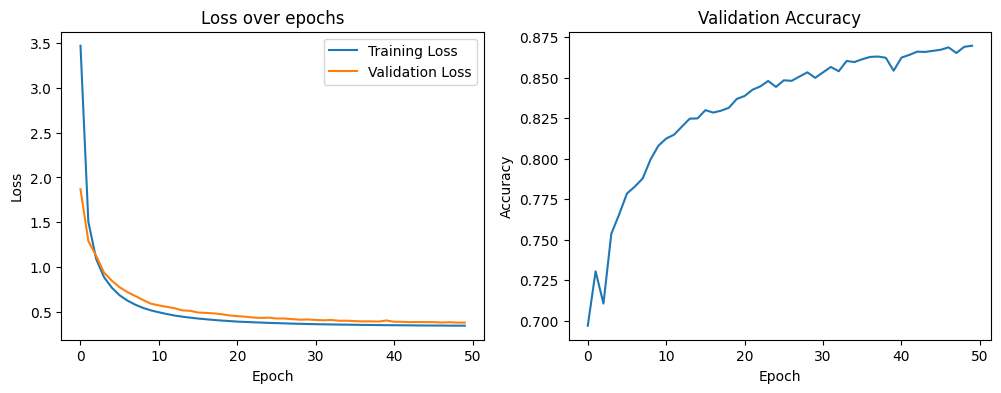

Validation accuracy: 0.8698
New best params found: {'lr': 0.0001, 'hidden_size': 100, 'reg_lambda': 0.2, 'batch_size': 32}, val_acc: 0.8698
Training with lr=0.0001, hidden_size=100, reg_lambda=0.2, batch_size=64
Epoch 1, Train Loss: 4.4317
Epoch 1, Validation Accuracy: 0.6788
Epoch 2, Train Loss: 2.3658
Epoch 2, Validation Accuracy: 0.7178
Epoch 3, Train Loss: 1.7663
Epoch 3, Validation Accuracy: 0.7087
Epoch 4, Train Loss: 1.4566
Epoch 4, Validation Accuracy: 0.7455
Epoch 5, Train Loss: 1.2250
Epoch 5, Validation Accuracy: 0.7216
Epoch 6, Train Loss: 1.0779
Epoch 6, Validation Accuracy: 0.7292
Epoch 7, Train Loss: 0.9725
Epoch 7, Validation Accuracy: 0.7459
Epoch 8, Train Loss: 0.8871
Epoch 8, Validation Accuracy: 0.7624
Epoch 9, Train Loss: 0.8154
Epoch 9, Validation Accuracy: 0.7687
Epoch 10, Train Loss: 0.7638
Epoch 10, Validation Accuracy: 0.7751
Epoch 11, Train Loss: 0.7124
Epoch 11, Validation Accuracy: 0.7827
Epoch 12, Train Loss: 0.6730
Epoch 12, Validation Accuracy: 0.7564
Ep

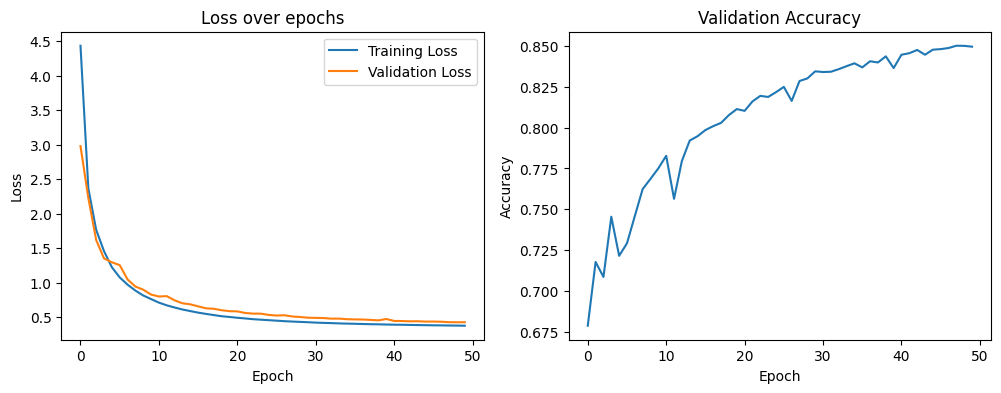

Validation accuracy: 0.8495
Training with lr=0.0001, hidden_size=150, reg_lambda=0.1, batch_size=32
Epoch 1, Train Loss: 3.5904
Epoch 1, Validation Accuracy: 0.7503
Epoch 2, Train Loss: 1.7037
Epoch 2, Validation Accuracy: 0.7532
Epoch 3, Train Loss: 1.2245
Epoch 3, Validation Accuracy: 0.7631
Epoch 4, Train Loss: 0.9926
Epoch 4, Validation Accuracy: 0.7519
Epoch 5, Train Loss: 0.8408
Epoch 5, Validation Accuracy: 0.7788
Epoch 6, Train Loss: 0.7433
Epoch 6, Validation Accuracy: 0.7650
Epoch 7, Train Loss: 0.6732
Epoch 7, Validation Accuracy: 0.8024
Epoch 8, Train Loss: 0.6193
Epoch 8, Validation Accuracy: 0.7981
Epoch 9, Train Loss: 0.5778
Epoch 9, Validation Accuracy: 0.8001
Epoch 10, Train Loss: 0.5433
Epoch 10, Validation Accuracy: 0.8097
Epoch 11, Train Loss: 0.5174
Epoch 11, Validation Accuracy: 0.8053
Epoch 12, Train Loss: 0.4938
Epoch 12, Validation Accuracy: 0.8156
Epoch 13, Train Loss: 0.4740
Epoch 13, Validation Accuracy: 0.8147
Epoch 14, Train Loss: 0.4565
Epoch 14, Validati

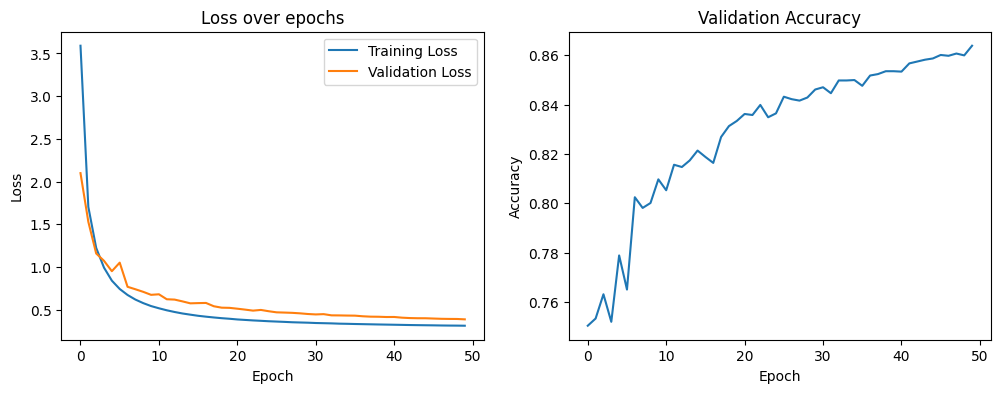

Validation accuracy: 0.8638
Training with lr=0.0001, hidden_size=150, reg_lambda=0.1, batch_size=64
Epoch 1, Train Loss: 4.5033
Epoch 1, Validation Accuracy: 0.7353
Epoch 2, Train Loss: 2.7034
Epoch 2, Validation Accuracy: 0.7574
Epoch 3, Train Loss: 2.0938
Epoch 3, Validation Accuracy: 0.7589
Epoch 4, Train Loss: 1.6961
Epoch 4, Validation Accuracy: 0.7699
Epoch 5, Train Loss: 1.4526
Epoch 5, Validation Accuracy: 0.7655
Epoch 6, Train Loss: 1.2488
Epoch 6, Validation Accuracy: 0.7738
Epoch 7, Train Loss: 1.1150
Epoch 7, Validation Accuracy: 0.7737
Epoch 8, Train Loss: 1.0016
Epoch 8, Validation Accuracy: 0.7827
Epoch 9, Train Loss: 0.9231
Epoch 9, Validation Accuracy: 0.7911
Epoch 10, Train Loss: 0.8527
Epoch 10, Validation Accuracy: 0.7892
Epoch 11, Train Loss: 0.7871
Epoch 11, Validation Accuracy: 0.7983
Epoch 12, Train Loss: 0.7436
Epoch 12, Validation Accuracy: 0.8018
Epoch 13, Train Loss: 0.7033
Epoch 13, Validation Accuracy: 0.7935
Epoch 14, Train Loss: 0.6663
Epoch 14, Validati

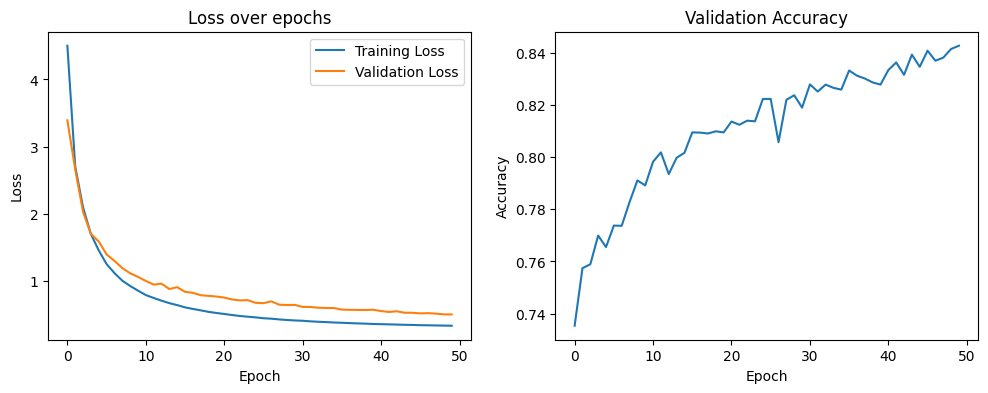

Validation accuracy: 0.8427
Training with lr=0.0001, hidden_size=150, reg_lambda=0.2, batch_size=32
Epoch 1, Train Loss: 3.5353
Epoch 1, Validation Accuracy: 0.7493
Epoch 2, Train Loss: 1.6475
Epoch 2, Validation Accuracy: 0.7734
Epoch 3, Train Loss: 1.1718
Epoch 3, Validation Accuracy: 0.7772
Epoch 4, Train Loss: 0.9228
Epoch 4, Validation Accuracy: 0.7936
Epoch 5, Train Loss: 0.7647
Epoch 5, Validation Accuracy: 0.7790
Epoch 6, Train Loss: 0.6621
Epoch 6, Validation Accuracy: 0.8059
Epoch 7, Train Loss: 0.5924
Epoch 7, Validation Accuracy: 0.8090
Epoch 8, Train Loss: 0.5437
Epoch 8, Validation Accuracy: 0.8046
Epoch 9, Train Loss: 0.5028
Epoch 9, Validation Accuracy: 0.8194
Epoch 10, Train Loss: 0.4721
Epoch 10, Validation Accuracy: 0.8224
Epoch 11, Train Loss: 0.4511
Epoch 11, Validation Accuracy: 0.8262
Epoch 12, Train Loss: 0.4316
Epoch 12, Validation Accuracy: 0.8310
Epoch 13, Train Loss: 0.4161
Epoch 13, Validation Accuracy: 0.8327
Epoch 14, Train Loss: 0.4034
Epoch 14, Validati

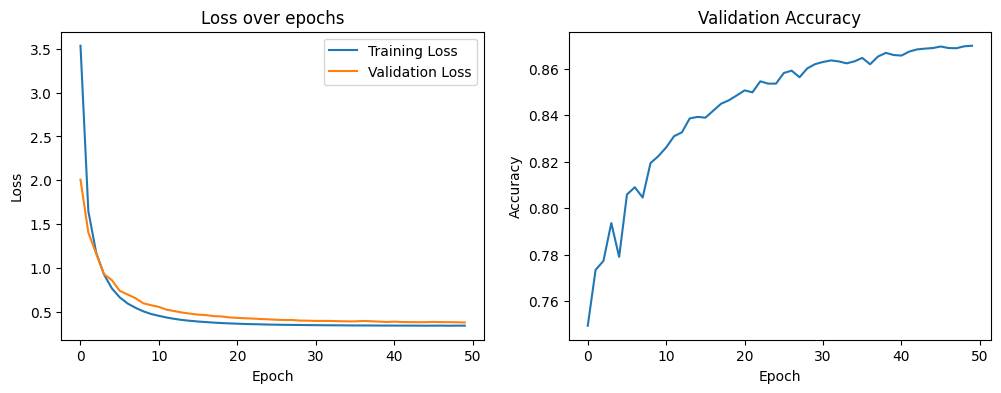

Validation accuracy: 0.8700
New best params found: {'lr': 0.0001, 'hidden_size': 150, 'reg_lambda': 0.2, 'batch_size': 32}, val_acc: 0.8700
Training with lr=0.0001, hidden_size=150, reg_lambda=0.2, batch_size=64
Epoch 1, Train Loss: 4.4189
Epoch 1, Validation Accuracy: 0.7313
Epoch 2, Train Loss: 2.5100
Epoch 2, Validation Accuracy: 0.7573
Epoch 3, Train Loss: 1.8721
Epoch 3, Validation Accuracy: 0.7723
Epoch 4, Train Loss: 1.5070
Epoch 4, Validation Accuracy: 0.7488
Epoch 5, Train Loss: 1.2528
Epoch 5, Validation Accuracy: 0.7782
Epoch 6, Train Loss: 1.0832
Epoch 6, Validation Accuracy: 0.7558
Epoch 7, Train Loss: 0.9588
Epoch 7, Validation Accuracy: 0.7701
Epoch 8, Train Loss: 0.8585
Epoch 8, Validation Accuracy: 0.7852
Epoch 9, Train Loss: 0.7840
Epoch 9, Validation Accuracy: 0.7856
Epoch 10, Train Loss: 0.7188
Epoch 10, Validation Accuracy: 0.7973
Epoch 11, Train Loss: 0.6728
Epoch 11, Validation Accuracy: 0.7983
Epoch 12, Train Loss: 0.6327
Epoch 12, Validation Accuracy: 0.8051
Ep

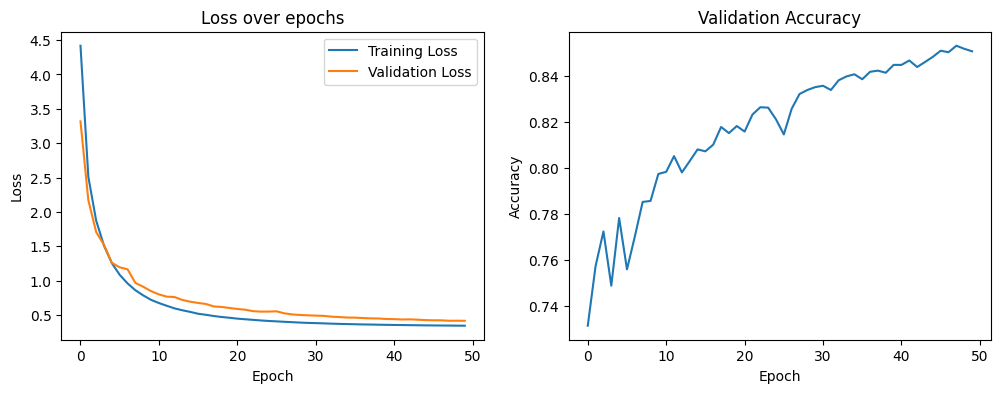

Validation accuracy: 0.8507
Training with lr=0.0001, hidden_size=200, reg_lambda=0.1, batch_size=32
Epoch 1, Train Loss: 3.7523
Epoch 1, Validation Accuracy: 0.7598
Epoch 2, Train Loss: 1.9001
Epoch 2, Validation Accuracy: 0.7513
Epoch 3, Train Loss: 1.3260
Epoch 3, Validation Accuracy: 0.7897
Epoch 4, Train Loss: 1.0233
Epoch 4, Validation Accuracy: 0.7933
Epoch 5, Train Loss: 0.8445
Epoch 5, Validation Accuracy: 0.7619
Epoch 6, Train Loss: 0.7283
Epoch 6, Validation Accuracy: 0.8042
Epoch 7, Train Loss: 0.6426
Epoch 7, Validation Accuracy: 0.8016
Epoch 8, Train Loss: 0.5820
Epoch 8, Validation Accuracy: 0.7957
Epoch 9, Train Loss: 0.5392
Epoch 9, Validation Accuracy: 0.7977
Epoch 10, Train Loss: 0.5028
Epoch 10, Validation Accuracy: 0.8205
Epoch 11, Train Loss: 0.4744
Epoch 11, Validation Accuracy: 0.8205
Epoch 12, Train Loss: 0.4515
Epoch 12, Validation Accuracy: 0.8180
Epoch 13, Train Loss: 0.4311
Epoch 13, Validation Accuracy: 0.8147
Epoch 14, Train Loss: 0.4160
Epoch 14, Validati

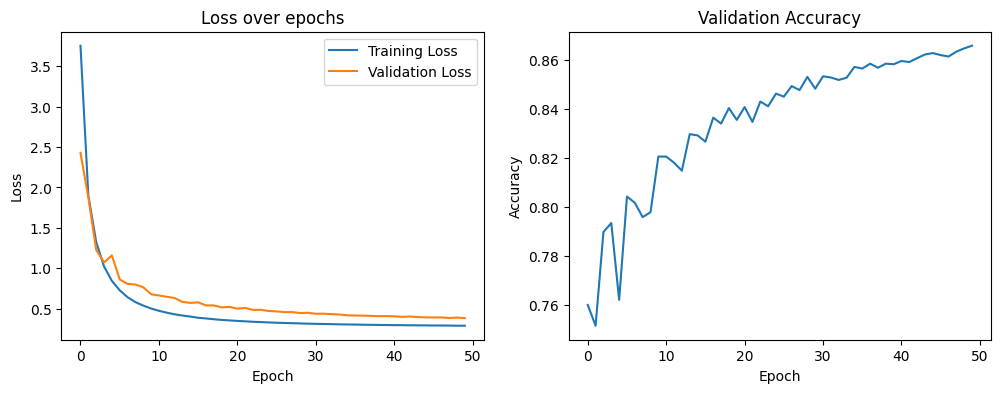

Validation accuracy: 0.8658
Training with lr=0.0001, hidden_size=200, reg_lambda=0.1, batch_size=64
Epoch 1, Train Loss: 4.4500
Epoch 1, Validation Accuracy: 0.7472
Epoch 2, Train Loss: 2.6121
Epoch 2, Validation Accuracy: 0.7565
Epoch 3, Train Loss: 1.9651
Epoch 3, Validation Accuracy: 0.7723
Epoch 4, Train Loss: 1.6285
Epoch 4, Validation Accuracy: 0.7523
Epoch 5, Train Loss: 1.3931
Epoch 5, Validation Accuracy: 0.7494
Epoch 6, Train Loss: 1.2280
Epoch 6, Validation Accuracy: 0.7776
Epoch 7, Train Loss: 1.1098
Epoch 7, Validation Accuracy: 0.7808
Epoch 8, Train Loss: 1.0094
Epoch 8, Validation Accuracy: 0.7918
Epoch 9, Train Loss: 0.9171
Epoch 9, Validation Accuracy: 0.7933
Epoch 10, Train Loss: 0.8418
Epoch 10, Validation Accuracy: 0.7960
Epoch 11, Train Loss: 0.7827
Epoch 11, Validation Accuracy: 0.7989
Epoch 12, Train Loss: 0.7339
Epoch 12, Validation Accuracy: 0.7949
Epoch 13, Train Loss: 0.6912
Epoch 13, Validation Accuracy: 0.7894
Epoch 14, Train Loss: 0.6509
Epoch 14, Validati

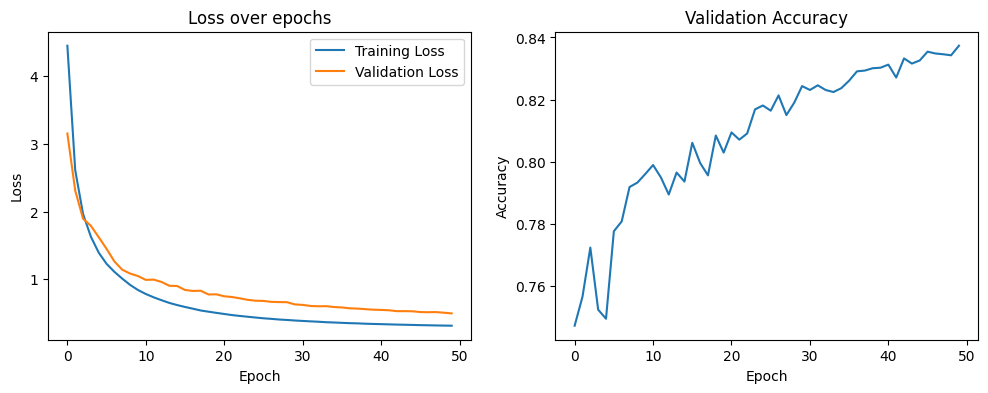

Validation accuracy: 0.8373
Training with lr=0.0001, hidden_size=200, reg_lambda=0.2, batch_size=32
Epoch 1, Train Loss: 3.6683
Epoch 1, Validation Accuracy: 0.7713
Epoch 2, Train Loss: 1.8497
Epoch 2, Validation Accuracy: 0.7723
Epoch 3, Train Loss: 1.2590
Epoch 3, Validation Accuracy: 0.7887
Epoch 4, Train Loss: 0.9594
Epoch 4, Validation Accuracy: 0.7918
Epoch 5, Train Loss: 0.7747
Epoch 5, Validation Accuracy: 0.7981
Epoch 6, Train Loss: 0.6559
Epoch 6, Validation Accuracy: 0.8099
Epoch 7, Train Loss: 0.5748
Epoch 7, Validation Accuracy: 0.8155
Epoch 8, Train Loss: 0.5153
Epoch 8, Validation Accuracy: 0.8157
Epoch 9, Train Loss: 0.4734
Epoch 9, Validation Accuracy: 0.8178
Epoch 10, Train Loss: 0.4435
Epoch 10, Validation Accuracy: 0.8235
Epoch 11, Train Loss: 0.4175
Epoch 11, Validation Accuracy: 0.8263
Epoch 12, Train Loss: 0.4002
Epoch 12, Validation Accuracy: 0.8357
Epoch 13, Train Loss: 0.3850
Epoch 13, Validation Accuracy: 0.8350
Epoch 14, Train Loss: 0.3723
Epoch 14, Validati

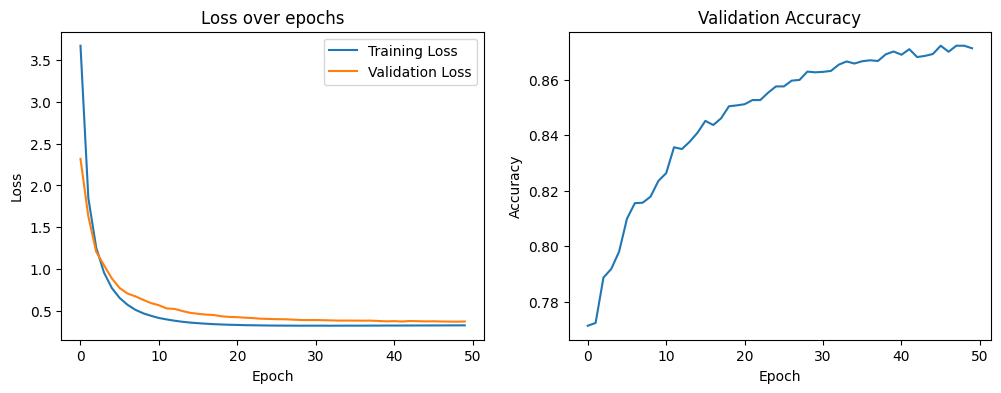

Validation accuracy: 0.8713
New best params found: {'lr': 0.0001, 'hidden_size': 200, 'reg_lambda': 0.2, 'batch_size': 32}, val_acc: 0.8713
Training with lr=0.0001, hidden_size=200, reg_lambda=0.2, batch_size=64
Epoch 1, Train Loss: 4.4247
Epoch 1, Validation Accuracy: 0.7389
Epoch 2, Train Loss: 2.6017
Epoch 2, Validation Accuracy: 0.7492
Epoch 3, Train Loss: 1.9764
Epoch 3, Validation Accuracy: 0.7791
Epoch 4, Train Loss: 1.5679
Epoch 4, Validation Accuracy: 0.7722
Epoch 5, Train Loss: 1.3064
Epoch 5, Validation Accuracy: 0.7893
Epoch 6, Train Loss: 1.1220
Epoch 6, Validation Accuracy: 0.7774
Epoch 7, Train Loss: 0.9926
Epoch 7, Validation Accuracy: 0.7822
Epoch 8, Train Loss: 0.8813
Epoch 8, Validation Accuracy: 0.7789
Epoch 9, Train Loss: 0.7972
Epoch 9, Validation Accuracy: 0.7979
Epoch 10, Train Loss: 0.7238
Epoch 10, Validation Accuracy: 0.7961
Epoch 11, Train Loss: 0.6713
Epoch 11, Validation Accuracy: 0.7979
Epoch 12, Train Loss: 0.6223
Epoch 12, Validation Accuracy: 0.8110
Ep

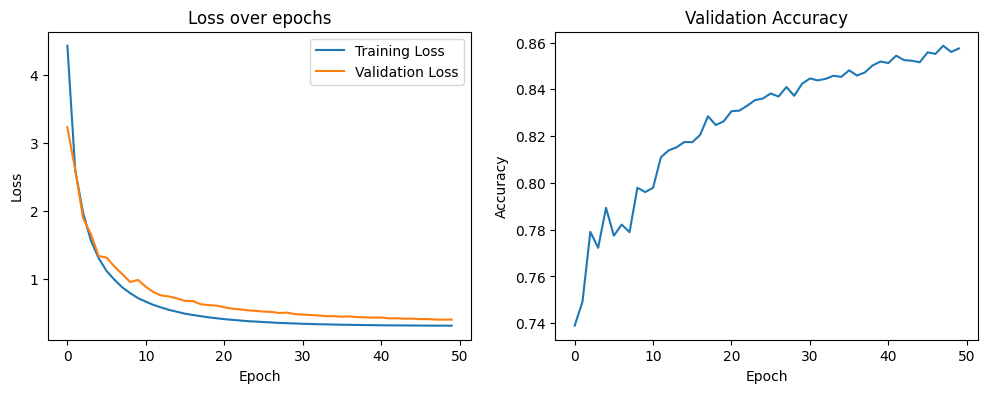

Validation accuracy: 0.8575
Training with lr=5e-05, hidden_size=100, reg_lambda=0.1, batch_size=32
Epoch 1, Train Loss: 4.5765
Epoch 1, Validation Accuracy: 0.7077
Epoch 2, Train Loss: 2.5303
Epoch 2, Validation Accuracy: 0.7348
Epoch 3, Train Loss: 1.8892
Epoch 3, Validation Accuracy: 0.7496
Epoch 4, Train Loss: 1.5531
Epoch 4, Validation Accuracy: 0.7369
Epoch 5, Train Loss: 1.3044
Epoch 5, Validation Accuracy: 0.7507
Epoch 6, Train Loss: 1.1392
Epoch 6, Validation Accuracy: 0.7625
Epoch 7, Train Loss: 1.0245
Epoch 7, Validation Accuracy: 0.7700
Epoch 8, Train Loss: 0.9269
Epoch 8, Validation Accuracy: 0.7529
Epoch 9, Train Loss: 0.8590
Epoch 9, Validation Accuracy: 0.7736
Epoch 10, Train Loss: 0.7962
Epoch 10, Validation Accuracy: 0.7588
Epoch 11, Train Loss: 0.7522
Epoch 11, Validation Accuracy: 0.7779
Epoch 12, Train Loss: 0.7122
Epoch 12, Validation Accuracy: 0.7608
Epoch 13, Train Loss: 0.6807
Epoch 13, Validation Accuracy: 0.7840
Epoch 14, Train Loss: 0.6523
Epoch 14, Validatio

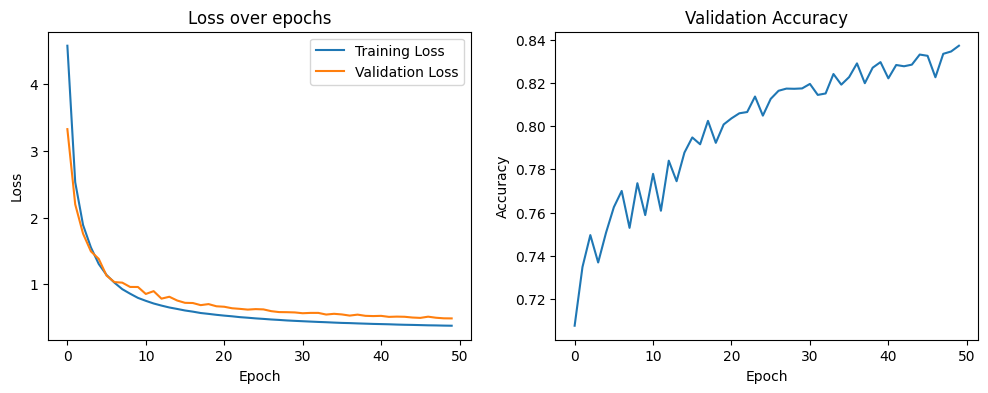

Validation accuracy: 0.8372
Training with lr=5e-05, hidden_size=100, reg_lambda=0.1, batch_size=64
Epoch 1, Train Loss: 5.4980
Epoch 1, Validation Accuracy: 0.6856
Epoch 2, Train Loss: 3.1544
Epoch 2, Validation Accuracy: 0.7130
Epoch 3, Train Loss: 2.4801
Epoch 3, Validation Accuracy: 0.7194
Epoch 4, Train Loss: 2.0839
Epoch 4, Validation Accuracy: 0.7342
Epoch 5, Train Loss: 1.8122
Epoch 5, Validation Accuracy: 0.7382
Epoch 6, Train Loss: 1.6168
Epoch 6, Validation Accuracy: 0.7425
Epoch 7, Train Loss: 1.4687
Epoch 7, Validation Accuracy: 0.7445
Epoch 8, Train Loss: 1.3596
Epoch 8, Validation Accuracy: 0.7426
Epoch 9, Train Loss: 1.2631
Epoch 9, Validation Accuracy: 0.7354
Epoch 10, Train Loss: 1.1792
Epoch 10, Validation Accuracy: 0.7531
Epoch 11, Train Loss: 1.1145
Epoch 11, Validation Accuracy: 0.7586
Epoch 12, Train Loss: 1.0514
Epoch 12, Validation Accuracy: 0.7534
Epoch 13, Train Loss: 1.0010
Epoch 13, Validation Accuracy: 0.7458
Epoch 14, Train Loss: 0.9539
Epoch 14, Validatio

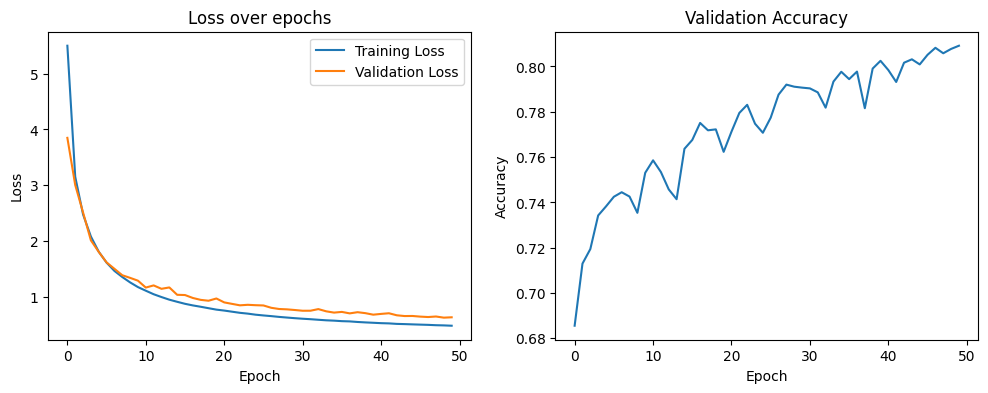

Validation accuracy: 0.8092
Training with lr=5e-05, hidden_size=100, reg_lambda=0.2, batch_size=32
Epoch 1, Train Loss: 4.4897
Epoch 1, Validation Accuracy: 0.7475
Epoch 2, Train Loss: 2.4515
Epoch 2, Validation Accuracy: 0.7423
Epoch 3, Train Loss: 1.8302
Epoch 3, Validation Accuracy: 0.7502
Epoch 4, Train Loss: 1.4887
Epoch 4, Validation Accuracy: 0.7688
Epoch 5, Train Loss: 1.2486
Epoch 5, Validation Accuracy: 0.7696
Epoch 6, Train Loss: 1.0786
Epoch 6, Validation Accuracy: 0.7782
Epoch 7, Train Loss: 0.9554
Epoch 7, Validation Accuracy: 0.7642
Epoch 8, Train Loss: 0.8632
Epoch 8, Validation Accuracy: 0.7879
Epoch 9, Train Loss: 0.7882
Epoch 9, Validation Accuracy: 0.7722
Epoch 10, Train Loss: 0.7310
Epoch 10, Validation Accuracy: 0.7708
Epoch 11, Train Loss: 0.6796
Epoch 11, Validation Accuracy: 0.7882
Epoch 12, Train Loss: 0.6413
Epoch 12, Validation Accuracy: 0.7983
Epoch 13, Train Loss: 0.6077
Epoch 13, Validation Accuracy: 0.8035
Epoch 14, Train Loss: 0.5780
Epoch 14, Validatio

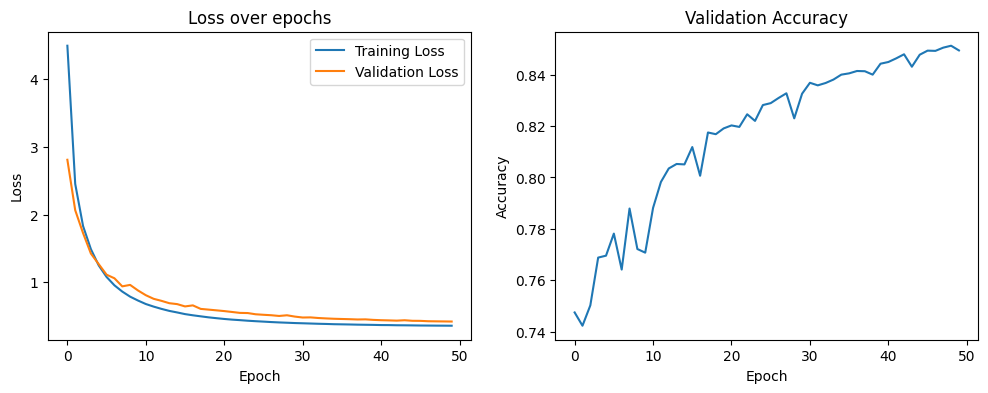

Validation accuracy: 0.8494
Training with lr=5e-05, hidden_size=100, reg_lambda=0.2, batch_size=64
Epoch 1, Train Loss: 5.3107
Epoch 1, Validation Accuracy: 0.6949
Epoch 2, Train Loss: 3.0631
Epoch 2, Validation Accuracy: 0.7057
Epoch 3, Train Loss: 2.3997
Epoch 3, Validation Accuracy: 0.7124
Epoch 4, Train Loss: 1.9873
Epoch 4, Validation Accuracy: 0.7403
Epoch 5, Train Loss: 1.6951
Epoch 5, Validation Accuracy: 0.7245
Epoch 6, Train Loss: 1.4840
Epoch 6, Validation Accuracy: 0.7478
Epoch 7, Train Loss: 1.3256
Epoch 7, Validation Accuracy: 0.7528
Epoch 8, Train Loss: 1.1991
Epoch 8, Validation Accuracy: 0.7343
Epoch 9, Train Loss: 1.1037
Epoch 9, Validation Accuracy: 0.7480
Epoch 10, Train Loss: 1.0176
Epoch 10, Validation Accuracy: 0.7585
Epoch 11, Train Loss: 0.9531
Epoch 11, Validation Accuracy: 0.7691
Epoch 12, Train Loss: 0.8970
Epoch 12, Validation Accuracy: 0.7662
Epoch 13, Train Loss: 0.8481
Epoch 13, Validation Accuracy: 0.7766
Epoch 14, Train Loss: 0.8186
Epoch 14, Validatio

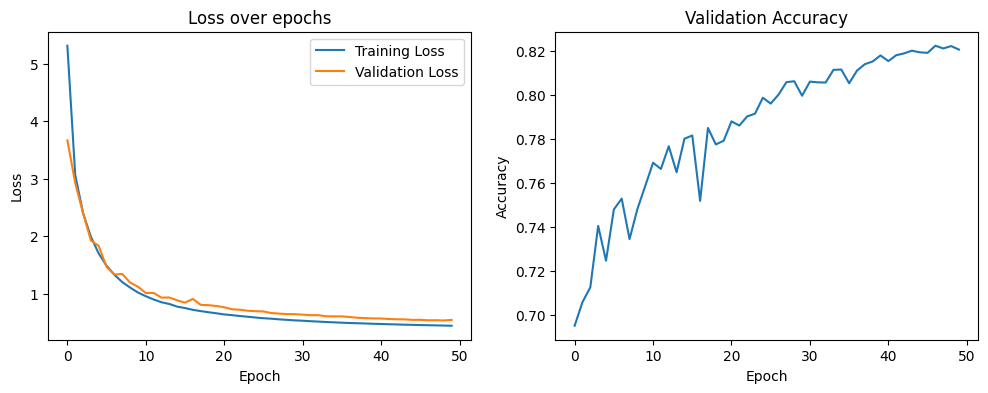

Validation accuracy: 0.8206
Training with lr=5e-05, hidden_size=150, reg_lambda=0.1, batch_size=32
Epoch 1, Train Loss: 4.5260
Epoch 1, Validation Accuracy: 0.7448
Epoch 2, Train Loss: 2.6926
Epoch 2, Validation Accuracy: 0.7462
Epoch 3, Train Loss: 2.0085
Epoch 3, Validation Accuracy: 0.7714
Epoch 4, Train Loss: 1.6068
Epoch 4, Validation Accuracy: 0.7766
Epoch 5, Train Loss: 1.3792
Epoch 5, Validation Accuracy: 0.7345
Epoch 6, Train Loss: 1.1969
Epoch 6, Validation Accuracy: 0.7737
Epoch 7, Train Loss: 1.0668
Epoch 7, Validation Accuracy: 0.7878
Epoch 8, Train Loss: 0.9622
Epoch 8, Validation Accuracy: 0.7935
Epoch 9, Train Loss: 0.8901
Epoch 9, Validation Accuracy: 0.7653
Epoch 10, Train Loss: 0.8184
Epoch 10, Validation Accuracy: 0.7954
Epoch 11, Train Loss: 0.7624
Epoch 11, Validation Accuracy: 0.8064
Epoch 12, Train Loss: 0.7288
Epoch 12, Validation Accuracy: 0.7957
Epoch 13, Train Loss: 0.6833
Epoch 13, Validation Accuracy: 0.8017
Epoch 14, Train Loss: 0.6482
Epoch 14, Validatio

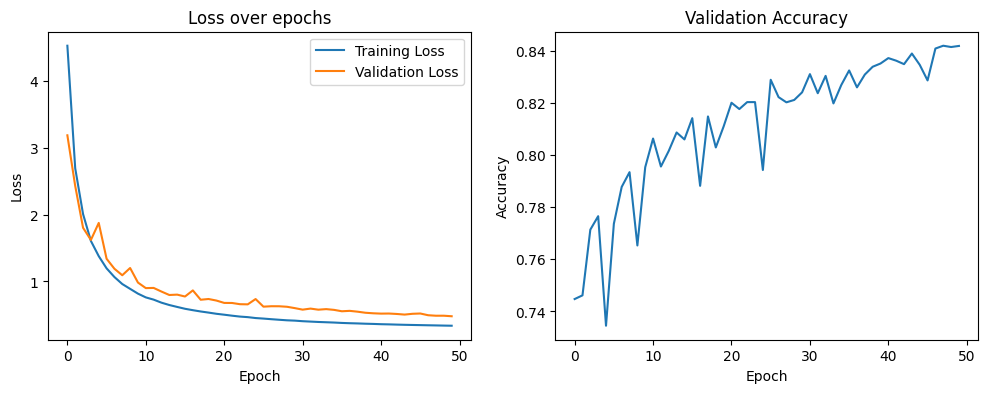

Validation accuracy: 0.8420
Training with lr=5e-05, hidden_size=150, reg_lambda=0.1, batch_size=64
Epoch 1, Train Loss: 5.3946
Epoch 1, Validation Accuracy: 0.7119
Epoch 2, Train Loss: 3.2937
Epoch 2, Validation Accuracy: 0.7480
Epoch 3, Train Loss: 2.6695
Epoch 3, Validation Accuracy: 0.7532
Epoch 4, Train Loss: 2.2884
Epoch 4, Validation Accuracy: 0.7548
Epoch 5, Train Loss: 2.0131
Epoch 5, Validation Accuracy: 0.7614
Epoch 6, Train Loss: 1.8108
Epoch 6, Validation Accuracy: 0.7492
Epoch 7, Train Loss: 1.6478
Epoch 7, Validation Accuracy: 0.7716
Epoch 8, Train Loss: 1.5060
Epoch 8, Validation Accuracy: 0.7726
Epoch 9, Train Loss: 1.4116
Epoch 9, Validation Accuracy: 0.7600
Epoch 10, Train Loss: 1.3124
Epoch 10, Validation Accuracy: 0.7836
Epoch 11, Train Loss: 1.2277
Epoch 11, Validation Accuracy: 0.7583
Epoch 12, Train Loss: 1.1600
Epoch 12, Validation Accuracy: 0.7708
Epoch 13, Train Loss: 1.0962
Epoch 13, Validation Accuracy: 0.7727
Epoch 14, Train Loss: 1.0471
Epoch 14, Validatio

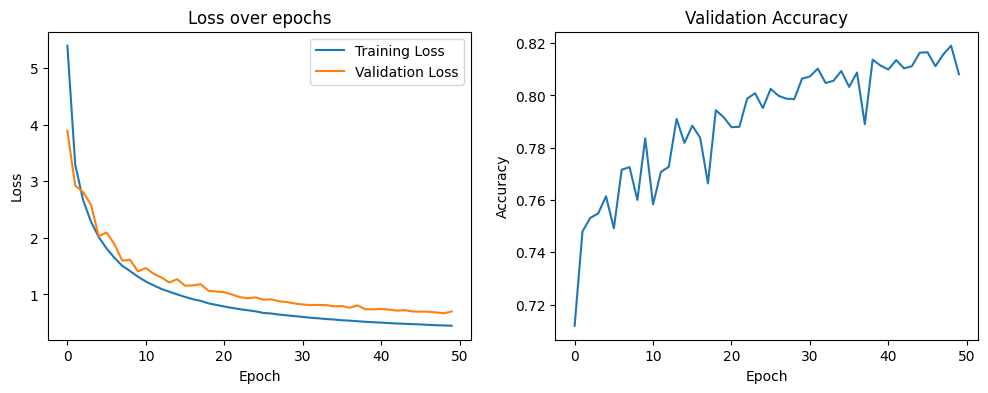

Validation accuracy: 0.8081
Training with lr=5e-05, hidden_size=150, reg_lambda=0.2, batch_size=32
Epoch 1, Train Loss: 4.3690
Epoch 1, Validation Accuracy: 0.7539
Epoch 2, Train Loss: 2.5897
Epoch 2, Validation Accuracy: 0.7708
Epoch 3, Train Loss: 1.9519
Epoch 3, Validation Accuracy: 0.7707
Epoch 4, Train Loss: 1.5685
Epoch 4, Validation Accuracy: 0.7692
Epoch 5, Train Loss: 1.3122
Epoch 5, Validation Accuracy: 0.7728
Epoch 6, Train Loss: 1.1187
Epoch 6, Validation Accuracy: 0.7541
Epoch 7, Train Loss: 0.9812
Epoch 7, Validation Accuracy: 0.7873
Epoch 8, Train Loss: 0.8818
Epoch 8, Validation Accuracy: 0.7985
Epoch 9, Train Loss: 0.7991
Epoch 9, Validation Accuracy: 0.7957
Epoch 10, Train Loss: 0.7354
Epoch 10, Validation Accuracy: 0.8077
Epoch 11, Train Loss: 0.6811
Epoch 11, Validation Accuracy: 0.7695
Epoch 12, Train Loss: 0.6355
Epoch 12, Validation Accuracy: 0.8079
Epoch 13, Train Loss: 0.5969
Epoch 13, Validation Accuracy: 0.8129
Epoch 14, Train Loss: 0.5670
Epoch 14, Validatio

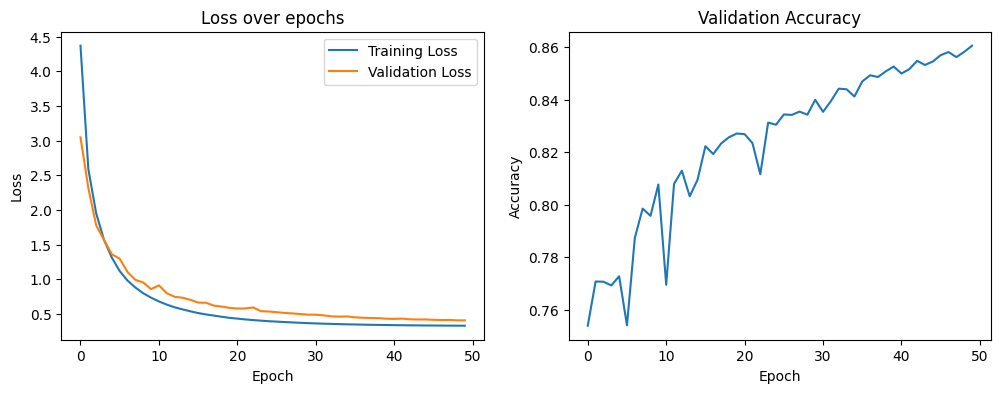

Validation accuracy: 0.8605
Training with lr=5e-05, hidden_size=150, reg_lambda=0.2, batch_size=64
Epoch 1, Train Loss: 5.4280
Epoch 1, Validation Accuracy: 0.7198
Epoch 2, Train Loss: 3.3948
Epoch 2, Validation Accuracy: 0.7452
Epoch 3, Train Loss: 2.8392
Epoch 3, Validation Accuracy: 0.7521
Epoch 4, Train Loss: 2.4227
Epoch 4, Validation Accuracy: 0.7676
Epoch 5, Train Loss: 2.1278
Epoch 5, Validation Accuracy: 0.7755
Epoch 6, Train Loss: 1.9027
Epoch 6, Validation Accuracy: 0.7783
Epoch 7, Train Loss: 1.7081
Epoch 7, Validation Accuracy: 0.7668
Epoch 8, Train Loss: 1.5544
Epoch 8, Validation Accuracy: 0.7850
Epoch 9, Train Loss: 1.4358
Epoch 9, Validation Accuracy: 0.7817
Epoch 10, Train Loss: 1.3176
Epoch 10, Validation Accuracy: 0.7849
Epoch 11, Train Loss: 1.2154
Epoch 11, Validation Accuracy: 0.7817
Epoch 12, Train Loss: 1.1387
Epoch 12, Validation Accuracy: 0.7760
Epoch 13, Train Loss: 1.0609
Epoch 13, Validation Accuracy: 0.7951
Epoch 14, Train Loss: 1.0065
Epoch 14, Validatio

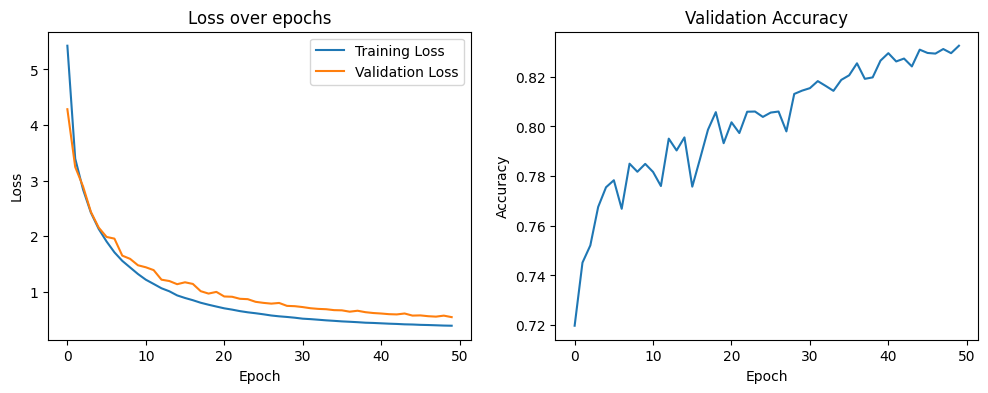

Validation accuracy: 0.8325
Training with lr=5e-05, hidden_size=200, reg_lambda=0.1, batch_size=32
Epoch 1, Train Loss: 4.3603
Epoch 1, Validation Accuracy: 0.7605
Epoch 2, Train Loss: 2.6832
Epoch 2, Validation Accuracy: 0.7720
Epoch 3, Train Loss: 2.0723
Epoch 3, Validation Accuracy: 0.7773
Epoch 4, Train Loss: 1.7023
Epoch 4, Validation Accuracy: 0.7786
Epoch 5, Train Loss: 1.4540
Epoch 5, Validation Accuracy: 0.7907
Epoch 6, Train Loss: 1.2720
Epoch 6, Validation Accuracy: 0.7833
Epoch 7, Train Loss: 1.1358
Epoch 7, Validation Accuracy: 0.7859
Epoch 8, Train Loss: 1.0193
Epoch 8, Validation Accuracy: 0.7913
Epoch 9, Train Loss: 0.9309
Epoch 9, Validation Accuracy: 0.7748
Epoch 10, Train Loss: 0.8479
Epoch 10, Validation Accuracy: 0.8034
Epoch 11, Train Loss: 0.7982
Epoch 11, Validation Accuracy: 0.8007
Epoch 12, Train Loss: 0.7450
Epoch 12, Validation Accuracy: 0.8017
Epoch 13, Train Loss: 0.6892
Epoch 13, Validation Accuracy: 0.7978
Epoch 14, Train Loss: 0.6548
Epoch 14, Validatio

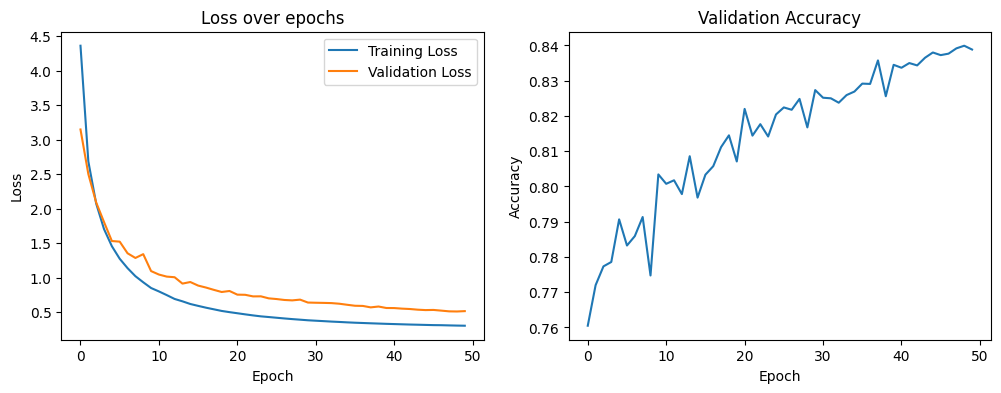

Validation accuracy: 0.8388
Training with lr=5e-05, hidden_size=200, reg_lambda=0.1, batch_size=64
Epoch 1, Train Loss: 5.2492
Epoch 1, Validation Accuracy: 0.7281
Epoch 2, Train Loss: 3.3804
Epoch 2, Validation Accuracy: 0.7548
Epoch 3, Train Loss: 2.7808
Epoch 3, Validation Accuracy: 0.7678
Epoch 4, Train Loss: 2.3852
Epoch 4, Validation Accuracy: 0.7860
Epoch 5, Train Loss: 2.0985
Epoch 5, Validation Accuracy: 0.7752
Epoch 6, Train Loss: 1.8974
Epoch 6, Validation Accuracy: 0.7830
Epoch 7, Train Loss: 1.7388
Epoch 7, Validation Accuracy: 0.7714
Epoch 8, Train Loss: 1.6131
Epoch 8, Validation Accuracy: 0.7838
Epoch 9, Train Loss: 1.4885
Epoch 9, Validation Accuracy: 0.7847
Epoch 10, Train Loss: 1.3918
Epoch 10, Validation Accuracy: 0.7887
Epoch 11, Train Loss: 1.3127
Epoch 11, Validation Accuracy: 0.7601
Epoch 12, Train Loss: 1.2398
Epoch 12, Validation Accuracy: 0.7915
Epoch 13, Train Loss: 1.1575
Epoch 13, Validation Accuracy: 0.7988
Epoch 14, Train Loss: 1.0968
Epoch 14, Validatio

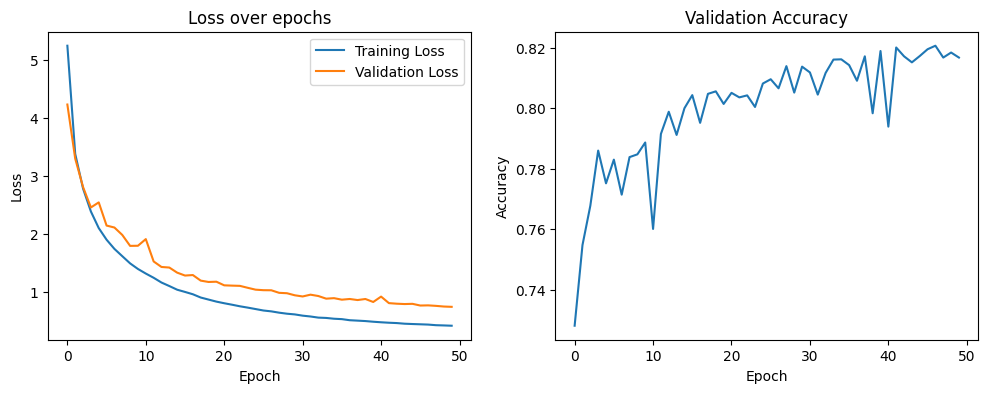

Validation accuracy: 0.8167
Training with lr=5e-05, hidden_size=200, reg_lambda=0.2, batch_size=32
Epoch 1, Train Loss: 4.4738
Epoch 1, Validation Accuracy: 0.7524
Epoch 2, Train Loss: 2.6370
Epoch 2, Validation Accuracy: 0.7755
Epoch 3, Train Loss: 1.9975
Epoch 3, Validation Accuracy: 0.7846
Epoch 4, Train Loss: 1.6080
Epoch 4, Validation Accuracy: 0.7853
Epoch 5, Train Loss: 1.3316
Epoch 5, Validation Accuracy: 0.7896
Epoch 6, Train Loss: 1.1556
Epoch 6, Validation Accuracy: 0.7879
Epoch 7, Train Loss: 1.0123
Epoch 7, Validation Accuracy: 0.7996
Epoch 8, Train Loss: 0.9023
Epoch 8, Validation Accuracy: 0.7888
Epoch 9, Train Loss: 0.8153
Epoch 9, Validation Accuracy: 0.8083
Epoch 10, Train Loss: 0.7412
Epoch 10, Validation Accuracy: 0.8103
Epoch 11, Train Loss: 0.6784
Epoch 11, Validation Accuracy: 0.8011
Epoch 12, Train Loss: 0.6326
Epoch 12, Validation Accuracy: 0.8133
Epoch 13, Train Loss: 0.5922
Epoch 13, Validation Accuracy: 0.8147
Epoch 14, Train Loss: 0.5557
Epoch 14, Validatio

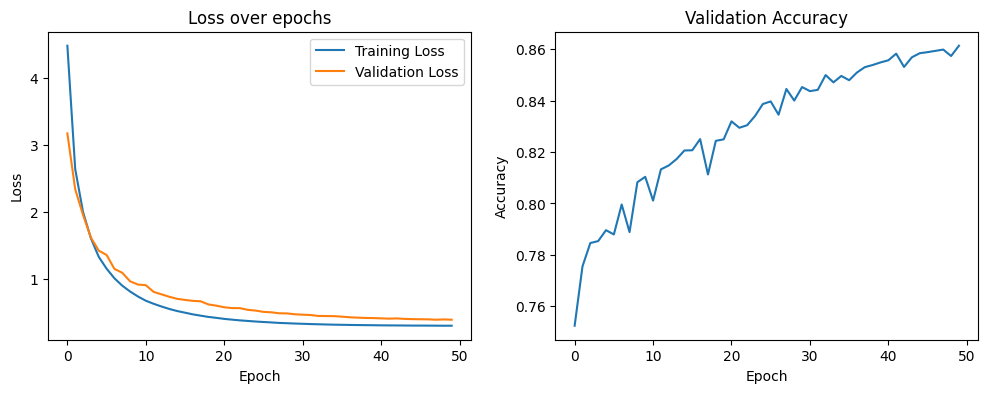

Validation accuracy: 0.8613
Training with lr=5e-05, hidden_size=200, reg_lambda=0.2, batch_size=64
Epoch 1, Train Loss: 5.1317
Epoch 1, Validation Accuracy: 0.7405
Epoch 2, Train Loss: 3.2902
Epoch 2, Validation Accuracy: 0.7557
Epoch 3, Train Loss: 2.7282
Epoch 3, Validation Accuracy: 0.7538
Epoch 4, Train Loss: 2.3628
Epoch 4, Validation Accuracy: 0.7807
Epoch 5, Train Loss: 2.0558
Epoch 5, Validation Accuracy: 0.7714
Epoch 6, Train Loss: 1.8172
Epoch 6, Validation Accuracy: 0.7734
Epoch 7, Train Loss: 1.6384
Epoch 7, Validation Accuracy: 0.7780
Epoch 8, Train Loss: 1.4709
Epoch 8, Validation Accuracy: 0.7842
Epoch 9, Train Loss: 1.3520
Epoch 9, Validation Accuracy: 0.7928
Epoch 10, Train Loss: 1.2389
Epoch 10, Validation Accuracy: 0.7942
Epoch 11, Train Loss: 1.1489
Epoch 11, Validation Accuracy: 0.7970
Epoch 12, Train Loss: 1.0676
Epoch 12, Validation Accuracy: 0.7977
Epoch 13, Train Loss: 1.0012
Epoch 13, Validation Accuracy: 0.8007
Epoch 14, Train Loss: 0.9389
Epoch 14, Validatio

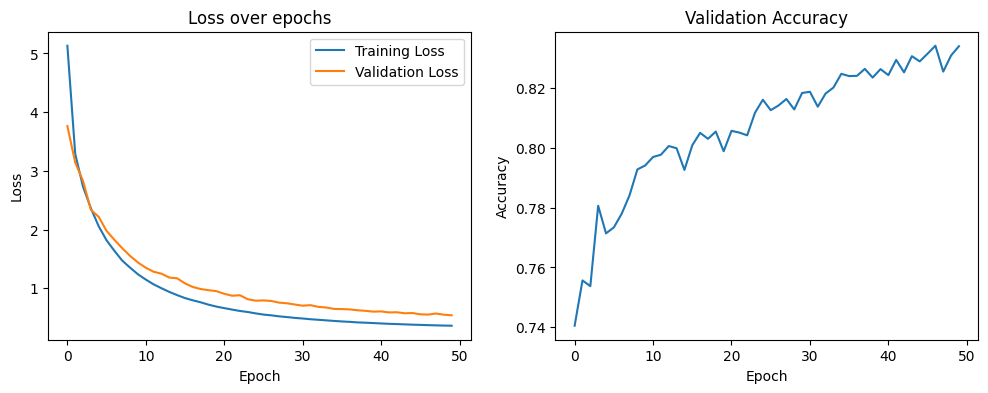

Validation accuracy: 0.8341
result: [(0.0001, 100, 0.1, 32, 0.8555), (0.0001, 100, 0.1, 64, 0.8349166666666666), (0.0001, 100, 0.2, 32, 0.86975), (0.0001, 100, 0.2, 64, 0.8495), (0.0001, 150, 0.1, 32, 0.8638333333333333), (0.0001, 150, 0.1, 64, 0.84275), (0.0001, 150, 0.2, 32, 0.87), (0.0001, 150, 0.2, 64, 0.8506666666666667), (0.0001, 200, 0.1, 32, 0.8658333333333333), (0.0001, 200, 0.1, 64, 0.8373333333333334), (0.0001, 200, 0.2, 32, 0.8713333333333333), (0.0001, 200, 0.2, 64, 0.8575), (5e-05, 100, 0.1, 32, 0.8371666666666666), (5e-05, 100, 0.1, 64, 0.8091666666666667), (5e-05, 100, 0.2, 32, 0.8494166666666667), (5e-05, 100, 0.2, 64, 0.8205833333333333), (5e-05, 150, 0.1, 32, 0.842), (5e-05, 150, 0.1, 64, 0.8080833333333334), (5e-05, 150, 0.2, 32, 0.8605), (5e-05, 150, 0.2, 64, 0.8325), (5e-05, 200, 0.1, 32, 0.8388333333333333), (5e-05, 200, 0.1, 64, 0.81675), (5e-05, 200, 0.2, 32, 0.8613333333333333), (5e-05, 200, 0.2, 64, 0.8340833333333333)]
Best params: {'lr': 0.0001, 'hidden_siz

In [79]:
best_params, best_accuracy,result=grid_search(train_images,train_labels,val_images, val_labels, input_size=784, output_size=10)
print("result:",result)
print("Best params:", best_params)
print("Best validation accuracy:", best_accuracy)

Epoch 1, Train Loss: 3.4682
Epoch 1, Validation Accuracy: 0.7654
Epoch 2, Train Loss: 1.6459
Epoch 2, Validation Accuracy: 0.7780
Epoch 3, Train Loss: 1.0928
Epoch 3, Validation Accuracy: 0.7676
Epoch 4, Train Loss: 0.8349
Epoch 4, Validation Accuracy: 0.7935
Epoch 5, Train Loss: 0.6848
Epoch 5, Validation Accuracy: 0.7990
Epoch 6, Train Loss: 0.5951
Epoch 6, Validation Accuracy: 0.8028
Epoch 7, Train Loss: 0.5343
Epoch 7, Validation Accuracy: 0.7948
Epoch 8, Train Loss: 0.4917
Epoch 8, Validation Accuracy: 0.8166
Epoch 9, Train Loss: 0.4595
Epoch 9, Validation Accuracy: 0.8068
Epoch 10, Train Loss: 0.4346
Epoch 10, Validation Accuracy: 0.8145
Epoch 11, Train Loss: 0.4162
Epoch 11, Validation Accuracy: 0.8265
Epoch 12, Train Loss: 0.4019
Epoch 12, Validation Accuracy: 0.8277
Epoch 13, Train Loss: 0.3897
Epoch 13, Validation Accuracy: 0.8262
Epoch 14, Train Loss: 0.3802
Epoch 14, Validation Accuracy: 0.8297
Epoch 15, Train Loss: 0.3723
Epoch 15, Validation Accuracy: 0.8333
Epoch 16, Tra

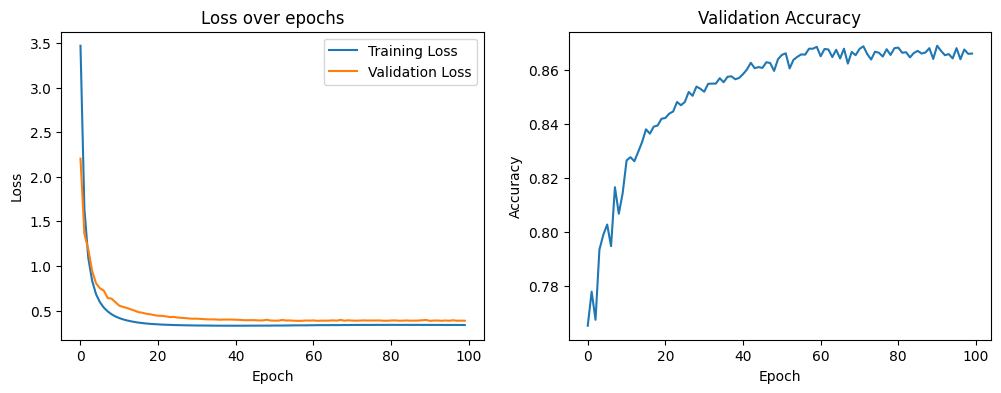

In [81]:
model=NeuralNetwork(input_size=784,hidden_size=200,output_size=10)
train(train_images,train_labels,test_images,test_labels,model,epochs=100,batch_size=32,lr=0.0001,reg_lambda=0.2)

In [83]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix

predictions = model.forward(test_images)

predicted_labels = np.argmax(predictions, axis=1)

accuracy = accuracy_score(test_labels, predicted_labels)

precision = precision_score(test_labels, predicted_labels, average='macro')

f1 = f1_score(test_labels, predicted_labels, average='macro')

conf_matrix = confusion_matrix(test_labels, predicted_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1 Score:", f1)
print(conf_matrix)

Accuracy: 0.866
Precision: 0.8667518168151739
F1 Score: 0.8660044125910785
[[805   3  13  37   4   0 125   0  13   0]
 [  4 963   2  23   5   0   1   0   2   0]
 [ 11   1 754  10 141   1  77   0   5   0]
 [ 24  12   9 871  47   1  32   0   4   0]
 [  0   0  89  25 821   0  61   0   4   0]
 [  0   0   0   1   0 942   0  30   2  25]
 [121   3  77  26  83   0 672   0  18   0]
 [  0   0   0   0   0  26   0 912   0  62]
 [  1   1   6   7   7   2  12   6 958   0]
 [  0   0   0   0   0   6   0  31   1 962]]


In [84]:
import pickle
with open('model_params.pkl', 'wb') as f:
    pickle.dump(model.params, f)

# 加载模型参数
with open('model_params.pkl', 'rb') as f:
    loaded_params = pickle.load(f)